In [152]:
# Run some setup code for this notebook.

import random
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
# Load the satellite dataset.
tiny_satellite_dir = 'data'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

def get_TINYSAT_data(root_path, split):
    # Get the training dataset!
    split_dir = os.path.join(root_path, split)
    filenames = os.listdir(split_dir)
    filenames = [os.path.join(split_dir, f) for f in filenames if f.endswith('.jpg')] 
    
    labels = [int(os.path.split(f)[-1][0]) for f in filenames]
    images = [np.asarray(Image.open(f).resize((64, 64), Image.BILINEAR)) for f in filenames]
    
    # Add pre-processing step of unsupervised kmeans segmentation
    # images = [draw_clusters_on_image(img, kmeans_segmentation(img, get_image_feature_vector(img), 7)) for img in images]
    
    X = np.array(images)
    y = np.array(labels)
    
    return X, y

X_train, y_train = get_TINYSAT_data(tiny_satellite_dir, "train")
X_test, y_test = get_TINYSAT_data(tiny_satellite_dir, "val")

# Save for later analysis
orig_X_train = X_train
orig_X_test = X_test

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (234, 64, 64, 3)
Training labels shape:  (234,)
Test data shape:  (17, 64, 64, 3)
Test labels shape:  (17,)


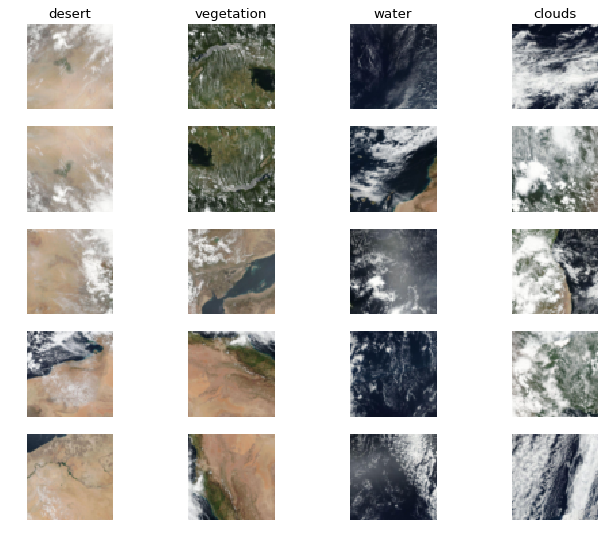

In [154]:
# Visualize some examples from the training dataset.
# We show a few examples of training images from each class.
classes = ['desert', 'vegetation', 'water', 'clouds']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [155]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(234, 12288) (17, 12288)


[128.50854701 125.34615385 119.14957265 127.68803419 124.65811966
 118.87179487 131.92735043 128.87606838 122.93162393 134.44444444]


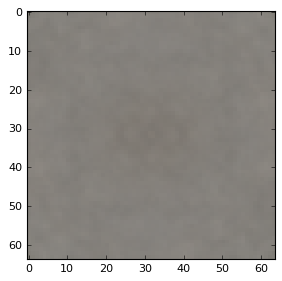

In [156]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((64,64,3)).astype('uint8')) # visualize the mean image
plt.show()

In [157]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# second: subtract the mean image from train and test data
X_train -= mean_image
X_test -= mean_image

In [158]:
from models.neural_net import TwoLayerNet

In [175]:
input_size = 64 * 64 * 3
hidden_size = 500
num_classes = len(classes)
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_test, y_test,
            num_iters=200, batch_size=500,
            learning_rate=1e-4, learning_rate_decay=1.00,
            reg=1.0, verbose=True)

# Predict on the validation set
y_test_prob, y_test_pred = net.predict(X_test)
val_acc = (y_test_pred == y_test).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 200: loss 1.417114
iteration 100 / 200: loss 0.728380
Validation accuracy:  0.8823529411764706


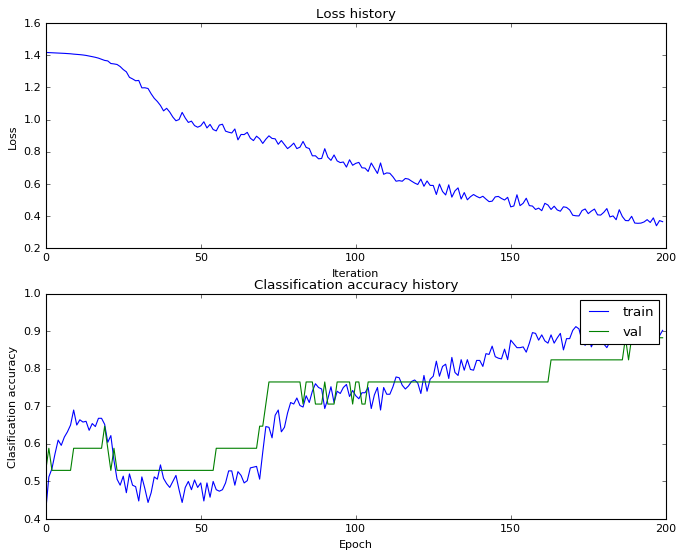

In [177]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [178]:
# Generate confusion matrix
# - results = list of tuples of (correct label, predicted label)
# - categories = list of category names
# Returns confusion matrix; rows are correct labels and columns are predictions
def confusion_matrix(results, categories, plotConfusion=False):
    # Empty confusion matrix
    matrix = np.zeros((len(categories),len(categories)))

    # Iterate over all labels and populate matrix
    for label, pred in results:
        matrix[label, pred] += 1

    # Print matrix and percent accuracy
    accuracy = float(np.trace(matrix)) * 100.0 / len(results)
    print('Accuracy: ' +  str(accuracy) + '%')

    # Normalize confusion matrix
    normalizeMatrix = True
    if normalizeMatrix:
      print("Non-normalized conf_matrix:")
      print(matrix)
      s = np.sum(matrix,1) # Sum each row
      for i in range(matrix.shape[0]):
        # Normalization handles class imbalance in training set
        matrix[i,:] /= s[i]

    # Save matrix to file:
    # np.save("confusion_matrix.npy",matrix)

    # Plot the confusion matrix
    if plotConfusion:
        plot_confusion_matrix(matrix, categories)

def plot_confusion_matrix(cm, names=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(4)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Add labels to confusion matrix:
    if names is None:
        names = range(cm.shape[0])

    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)

    plt.tight_layout()
    plt.ylabel('Correct label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy: 88.2352941176%
Non-normalized conf_matrix:
[[6. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 5.]]


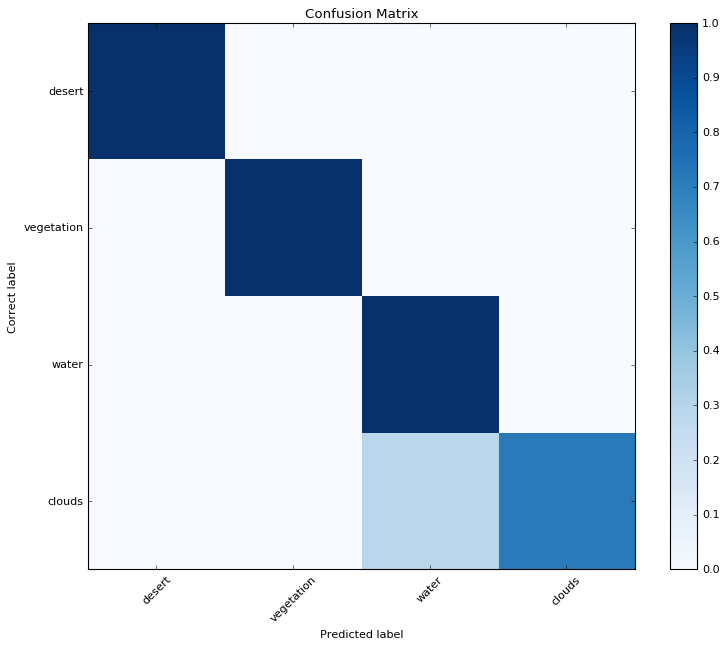

In [179]:
confusion_matrix(zip(y_test, y_test_pred), classes, plotConfusion=True)

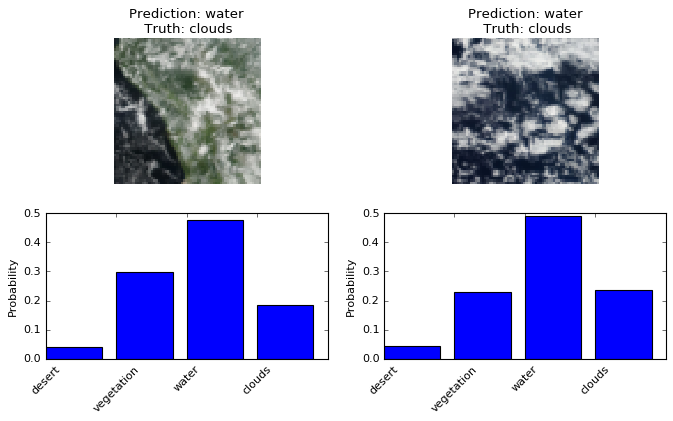

In [180]:
# Visualize misclassified examples from the test dataset.
classes = ['desert', 'vegetation', 'water', 'clouds']
num_classes = len(classes)
max_examples = 4

incorrect_idx = [idx for idx, incorrect in enumerate(y_test != y_test_pred) if incorrect]
if len(incorrect_idx) > max_examples:
    incorrect_idx = incorrect_idx[:max_examples]
num_incorrect = len(incorrect_idx)

for y, idx in enumerate(incorrect_idx):
    for i in range(3):
        plt_idx = i * num_incorrect + y + 1
        if i == 0:
            plt.subplot(3, num_incorrect, plt_idx)
            plt.imshow(orig_X_test[idx].astype('uint8'))
            plt.axis('off')
            plt.title("Prediction: %s\n Truth: %s" % (classes[y_test_pred[idx]], classes[y_test[idx]]))
        elif i == 1:
            plt.subplot(3, num_incorrect, plt_idx)
            probabilities = y_test_prob[idx]
            y_pos = np.arange(len(classes))
            plt.bar(y_pos, probabilities)
            plt.xticks(y_pos, classes, rotation=45)
            plt.ylabel("Probability")
plt.show()